In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors

In [34]:
dir_path = "/grid/siepel/home_norepl/mo/dom_adapt/bkgd_sims"
tag = 'bkgd'

file_paths = [f'{dir_path}/{tag}_swp_survey.tsv'
             ]

In [35]:
sc_gen_af = np.empty((0, 3))
for file in file_paths:
    sc_gen_af = np.vstack((sc_gen_af, np.genfromtxt(file, usecols=(2, 3, 4), invalid_raise=False)))

/cm/local/apps/python37/lib/python3.7/site-packages/ipykernel_launcher.py:3: ConversionWarning: Some errors were detected !
    Line #3338 (got 4 columns instead of 3)
    Line #17975 (got 4 columns instead of 3)
    Line #23878 (got 4 columns instead of 3)
    Line #24952 (got 4 columns instead of 3)
    Line #52153 (got 4 columns instead of 3)
    Line #62306 (got 4 columns instead of 3)
    Line #64211 (got 4 columns instead of 3)
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
sc_gen_af.shape

(65572, 3)

In [37]:
print("sc", sc_gen_af[:, 0].min(), "-", sc_gen_af[:, 0].max(), "gen", sc_gen_af[:, 1].min(), "-", sc_gen_af[:, 1].max(), "af", sc_gen_af[:, 2].min(), "-", sc_gen_af[:, 2].max())

sc 0.000100132 - 0.00999945 gen 100.0 - 10000.0 af 5e-05 - 1.0


### Examining range of generations

In [38]:
min_af = 0.05
max_af = 0.95

mask = np.logical_and(sc_gen_af[:, 2] > min_af, sc_gen_af[:, 2] < max_af)

In [39]:
np.sum(mask)

20898

In [40]:
gen = sc_gen_af[mask, 1]
sc = sc_gen_af[mask, 0]
AF = sc_gen_af[mask, 2]

In [24]:
gen = sc_gen_af[:, 1]
sc = sc_gen_af[:, 0]
AF = sc_gen_af[:, 2]

In [9]:
# set colormap
af_cmap = cm.get_cmap("summer", 101)
af_colour = af_cmap(np.linspace(0, 1, 101))

lost = np.array([0/256, 0/256, 0/256, 1])
low = np.array([128/256, 128/256, 128/256, 1])
high = np.array([255/256, 215/256, 0/256, 1])
fixed = np.array([255/256, 165/256, 0/256, 1])

af_colour[:1, :] = lost
af_colour[1:int(min_af*100), :] = low
af_colour[int(max_af*100):99, :] = high
af_colour[99:, :] = fixed

af_cmap = colors.ListedColormap(af_colour)

# af_cmap.set_over(color="#FF4500", alpha=0.3)
# af_cmap.set_under(color="#D0D0D0", alpha=0.3)

In [10]:
sc_min, sc_max, gen_min, gen_max = 1e-4, 1e-2, 100, 10000

In [11]:
sc_range = np.linspace(sc_min, sc_max)

In [12]:
def log_log_lin(sc_vec, k, b):
    return 10**b*np.power(sc_vec, -k)

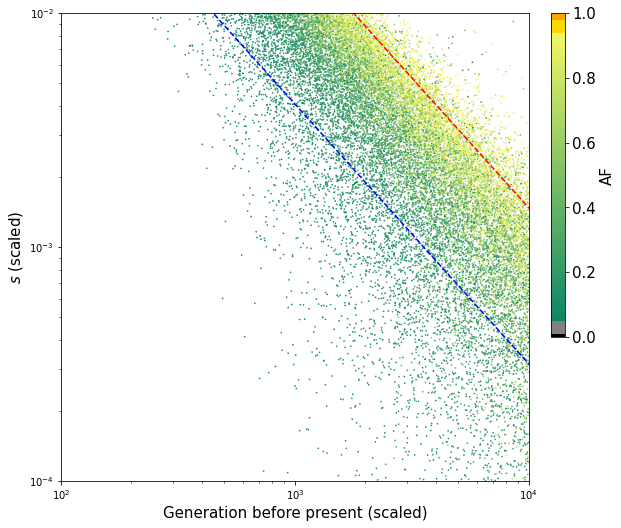

In [44]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h+0.01, bottom+0.2, 0.02, height-0.2]

# start with a rectangular Figure
plt.figure(1, figsize=(10, 10))

axScatter = plt.axes(rect_scatter)
#axDem = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)


# the scatter plot:
axScatter.scatter(gen, sc, c=AF, s=0.5, cmap=af_cmap, vmin=0, vmax=1, alpha=0.9) # change vmin, vmax!!

k = 0.9
b1 = 0.85
b2 = 1.45
axScatter.plot(log_log_lin(sc_range, k, b1), sc_range, "b--")
axScatter.plot(log_log_lin(sc_range, k, b2), sc_range, "r--")

#axScatter.axvline(x=2480, ymin=0.1, ymax=1, c='lightblue', ls='-')
#early_gen = np.around(np.maximum(2475 - 500*np.exp(-6*(sc_range-0.1)), 2460 - 180*np.exp(-7*(sc_range-0.1))))
#axScatter.plot(early_gen, sc_range, "g--") # Early generation fit
#late_gen = np.clip(np.around(2485 - 85*np.exp(-6.8*(sc_range-0.1))), a_min=2200, a_max=2480)
#axScatter.plot(late_gen, sc_range, "r--") # Late generation fit

axScatter.set_xlim((gen_min, gen_max))
axScatter.set_ylim((sc_min, sc_max))
axScatter.set_xlabel("Generation before present (scaled)", fontsize=15)
axScatter.set_ylabel("$s$ (scaled)", fontsize=15)
axScatter.set_yscale("log")
axScatter.set_xscale("log")

cbar = plt.colorbar(cm.ScalarMappable(cmap=af_cmap), cax=axHisty)
cbar.set_label('AF',size=15)
cbar.ax.tick_params(labelsize=15) 

#plt.savefig("/Users/mo/Desktop/sc_gen.001.01.pdf")
plt.show()

In [42]:
log_log_lin(0.01, k, b1), log_log_lin(0.01, k, b2)

(446.68359215096314, 1778.2794100389226)

In [43]:
log_log_lin(0.002, k, b1), log_log_lin(0.002, k, b2)

(1901.3978736655336, 7569.601275814215)

### Inspecting the sampling scheme (after simulations done)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

In [30]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(figsize=(15, 5))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

In [16]:
meta_df = np.genfromtxt('Ugi_1116_sft_scale10.meta', usecols=(1, 2, 3, 4, 5), invalid_raise=False)

In [2]:
meta_data = np.genfromtxt(f"SASC_1116_sft_scale10.meta", usecols=(1, 2, 3, 4, 5, 6), dtype=None, encoding=None)

In [3]:
meta_data.shape

(500000,)

In [9]:
list(meta_data[43215])

[0.047192,
 -2488,
 140,
 0.0700781,
 0.675246,
 'SASC_1116_sft_scale10/SASC_1116_sft_scale10_78216']

In [5]:
list(meta_data[12456])[:5], meta_data[12456][5]

([0.18213, -397, 43, 0.0266451, 0.474701],
 'SASC_1116_sft_scale10/SASC_1116_sft_scale10_497457')

In [15]:
meta_data

array([(0.033356, -1313, 338, 0.0300094, 0.880467, 'SASC_1116_sft_scale10/SASC_1116_sft_scale10_1'),
       (0.049644, -1836, 151, 0.098338 , 0.79128 , 'SASC_1116_sft_scale10/SASC_1116_sft_scale10_2'),
       (0.163863,  -768,  74, 0.0376127, 0.912899, 'SASC_1116_sft_scale10/SASC_1116_sft_scale10_3'),
       ...,
       (0.076976,  -396, 106, 0.0227762, 0.503432, 'SASC_1116_sft_scale10/SASC_1116_sft_scale10_494998'),
       (0.214257,  -449,  41, 0.0368726, 0.676356, 'SASC_1116_sft_scale10/SASC_1116_sft_scale10_494999'),
       (0.02581 , -3628, 460, 0.0972951, 0.974364, 'SASC_1116_sft_scale10/SASC_1116_sft_scale10_495000')],
      dtype=[('f0', '<f8'), ('f1', '<i8'), ('f2', '<i8'), ('f3', '<f8'), ('f4', '<f8'), ('f5', '<U50')])

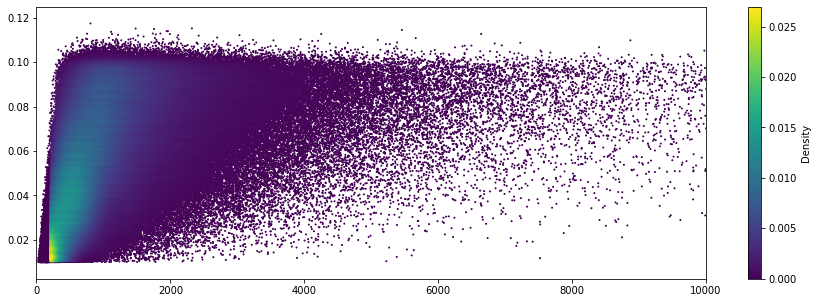

In [31]:
## For sft swp only: examine drift gen vs. init freq.


#fig, main_ax = plt.subplots(figsize=(10, 5))

#main_ax.scatter(-meta_df[:, 1], meta_df[:, 3], c=z, s=1)
#main_ax.set_yscale("log")
#main_ax.set_xscale("log")

ax = density_scatter(-meta_df[:, 1], meta_df[:, 3], bins = [100,100], s=1)
ax.set_xlim(0, 10000)
plt.show()

In [18]:
sc_range = np.linspace(0.1, 1)
gen = meta_df[:, 2]
sc = meta_df[:, 0]
AF = meta_df[:, 4]

In [19]:
np.min(sc)

0.01

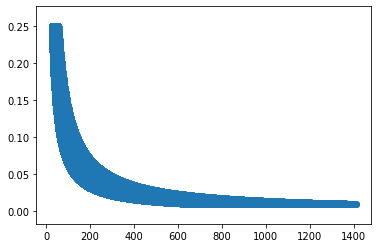

In [20]:
plt.scatter(gen, sc)

In [21]:
np.max(gen)

1411.0

(array([309215.,  76335.,  40204.,  26709.,  19340.,  12381.,   7817.,
          4752.,   2452.,    795.]),
 array([  25. ,  163.1,  301.2,  439.3,  577.4,  715.5,  853.6,  991.7,
        1129.8, 1267.9, 1406. ]),
 <a list of 10 Patch objects>)

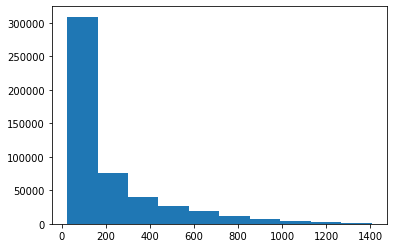

In [9]:
plt.hist(gen)

(array([3.1145e+04, 1.1687e+04, 4.3840e+03, 1.7090e+03, 6.9900e+02,
        2.3000e+02, 9.3000e+01, 3.6000e+01, 1.0000e+01, 7.0000e+00]),
 array([  50.01450527,  245.01305474,  440.01160421,  635.01015369,
         830.00870316, 1025.00725263, 1220.00580211, 1415.00435158,
        1610.00290105, 1805.00145053, 2000.        ]),
 <a list of 10 Patch objects>)

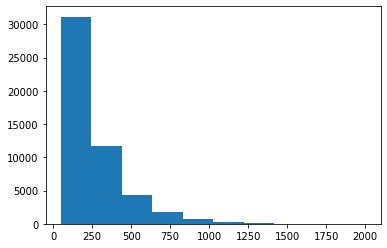

In [80]:
#
plt.hist(np.minimum(50+np.random.exponential(200, 50000), 2000))

In [78]:
np.max(np.minimum(50+np.random.exponential(180, 50000), 2000))

2000.0

(array([219.,  83.,  44.,  36.,  25.,  19.,  19.,  15.,  23.,  17.]),
 array([  50.10986014,  234.93842378,  419.76698741,  604.59555105,
         789.42411468,  974.25267832, 1159.08124196, 1343.90980559,
        1528.73836923, 1713.56693286, 1898.3954965 ]),
 <a list of 10 Patch objects>)

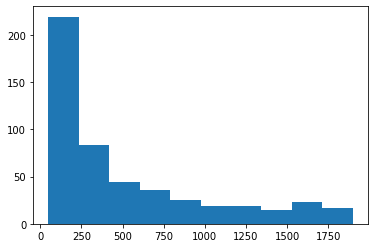

In [27]:
plt.hist(np.exp(np.random.uniform(np.log(50), np.log(1900), 500)))

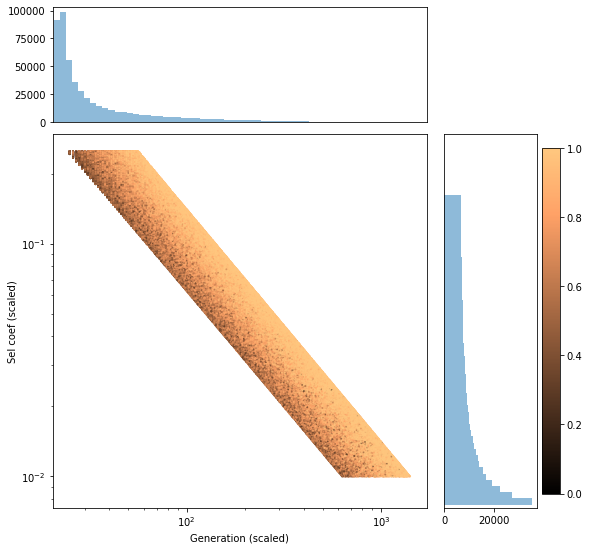

In [34]:
### Plot gen v sel coef ###
# set colormap
af_cmap = cm.get_cmap(name="copper")

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h+0.01, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.scatter(meta_df[:, 2], meta_df[:, 0], c=meta_df[:, 4], s=1, cmap=af_cmap, vmin=0, vmax=0.95, alpha=0.5) # change vmin, vmax!!
#early_gen = np.around(np.maximum(2475 - 500*np.exp(-6*(sc_range-0.1)), 2460 - 180*np.exp(-7*(sc_range-0.1))))
#axScatter.plot(early_gen, sc_range, "g--") # Early generation fit
#late_gen = np.clip(np.around(2485 - 85*np.exp(-6.8*(sc_range-0.1))), a_min=2200, a_max=2480)
#axScatter.plot(late_gen, sc_range, "r--") # Late generation fit

#axScatter.set_xlim((2200, 2500))
#axScatter.set_ylim((0, 1))
axScatter.set_xlabel("Generation (scaled)")
axScatter.set_ylabel("Sel coef (scaled)")
axScatter.set_yscale("log")
axScatter.set_xscale("log")

bins = 50
# axHistx.hist([x[~cat], x[cat]], alpha=0.5, bins=bins, color=[neg_color, pos_color], stacked=True)
axHistx.hist(meta_df[:, 2], alpha=0.5, bins=bins)


# axHisty.hist([y[~cat], y[cat]], alpha=0.5, bins=bins, orientation='horizontal', color=[neg_color, pos_color], stacked=True)
axHisty.hist(meta_df[:, 0], alpha=0.5, bins=bins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())
# axHisty.set_xlim((0, 500))
axHistx.set_xticks([])
axHisty.set_yticks([])

plt.colorbar(cm.ScalarMappable(cmap=af_cmap))
#plt.savefig(file_path+"_distr.pdf")
plt.show()

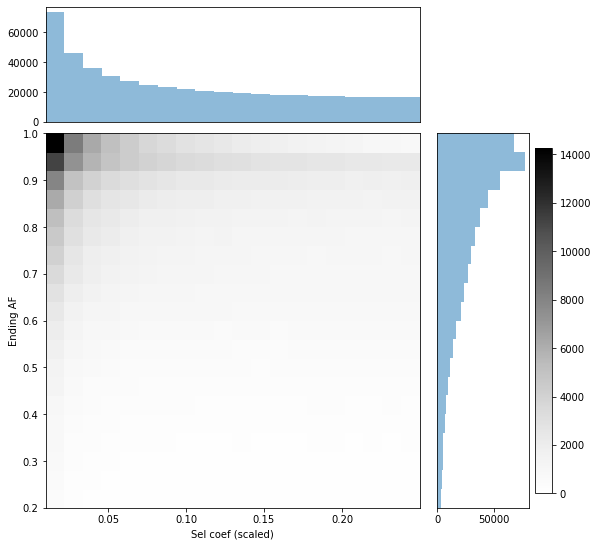

In [35]:
## Plot sel coef v. AF ##

no_bin = 20
hist_cmap = cm.get_cmap(name="Greys")
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h+0.01, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
#axHistx.xaxis.set_major_formatter(nullfmt)
#axHisty.yaxis.set_major_formatter(nullfmt)

# 2D histogram:
_, _, _, im = axScatter.hist2d(meta_df[:, 0], meta_df[:, 4], bins=no_bin, cmap=hist_cmap, vmin=0)

#axScatter.set_xlim((0, 1))
#axScatter.set_ylim((0, 1))
axScatter.set_xlabel("Sel coef (scaled)")
axScatter.set_ylabel("Ending AF")

axHistx.hist(meta_df[:, 0], alpha=0.5, bins=no_bin)
axHisty.hist(meta_df[:, 4], alpha=0.5, bins=no_bin, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())
# axHisty.set_xlim((0, 500))
axHistx.set_xticks([])
axHisty.set_yticks([])

plt.colorbar(im)
#plt.savefig(file_path+"_distr.pdf")
plt.show()